# 1. 이해하기

## 1.1 Agent-as-a-Tool (도구로 사용되는 에이전트)

*   **개념:** 다른 에이전트 인스턴스를 마치 일반적인 함수나 유틸리티처럼 **도구(Tool)로 래핑하여 사용하는 기능**입니다.
*   **구현:** ADK에서 `AgentTool` 클래스를 사용하여 다른 에이전트 인스턴스를 래핑합니다. 래핑된 `AgentTool` 인스턴스는 호출하는 상위 에이전트(Parent Agent)의 `tools` 목록에 추가됩니다. LLM은 자신의 지침(`instruction`) 및 도구 설명(`description`)을 바탕으로 이 도구를 언제 사용할지 결정합니다.
*   **제어 및 책임:**
    *   **호출하는 에이전트(Parent Agent)가 제어권을 유지합니다.** 사용자와의 대화 흐름을 관리하고 최종 응답을 생성하는 책임은 호출하는 에이전트에게 있습니다.
    *   호출된 에이전트(도구로 사용된 에이전트)는 요청받은 작업을 수행한 후 **그 결과를 호출하는 에이전트에게 반환합니다**.
    *   호출하는 에이전트는 반환받은 결과를 자신의 컨텍스트 내에서 가공하고 활용하여 사용자에게 최종 응답을 제공합니다.
*   **사용 시점:** 특정 전문 기능을 다른 에이전트에게 **위임**하고 그 결과를 받아와서 처리해야 할 때 유용합니다. 예를 들어, 연구 보고서 작성 에이전트가 검색 전문 에이전트를 도구로 사용하여 정보를 찾고, 요약 전문 에이전트를 도구로 사용하여 내용을 요약한 후, 이 결과를 바탕으로 보고서를 작성하는 경우입니다. 특정 작업을 다른 에이전트에게 분담시키되, 전체 워크플로우 제어는 상위 에이전트가 갖도록 할 때 사용합니다.



## 1.2 Sub-agent (하위 에이전트)

*   **개념:** 상위 에이전트(Parent Agent)의 계층 구조 아래에 속하는 전문화된 에이전트입니다.
*   **구현:** 상위 에이전트 정의 시 `sub_agents` 파라미터에 하위 에이전트 인스턴스 목록을 전달하여 설정합니다. ADK는 이 `sub_agents` 목록을 바탕으로 **자동 위임(Automatic Delegation)** 기능을 지원합니다. 상위 에이전트의 LLM은 하위 에이전트의 `description` 필드를 참조하여, 사용자 질의가 특정 하위 에이전트의 능력과 더 잘 맞는다고 판단하면 자동으로 제어권을 해당 하위 에이전트로 넘깁니다.
*   **제어 및 책임:**
    *   상위 에이전트가 하위 에이전트에게 작업을 위임하면, **사용자 응답 책임이 하위 에이전트로 완전히 이전됩니다**.
    *   하위 에이전트가 사용자와 직접 상호작용하며 응답을 생성합니다.
    *   이후의 사용자 입력은 일반적으로 해당 하위 에이전트가 처리합니다 (하위 에이전트가 명시적으로 다시 상위 에이전트로 제어권을 넘기지 않는 한). 이는 대화의 **라우팅**과 유사합니다.
*   **사용 시점:** 복잡한 시스템을 여러 개의 전문화된 에이전트로 분해하고, 각 에이전트가 특정 유형의 사용자 요청을 전담하여 처리하도록 할 때 사용합니다. 예를 들어, 날씨 질문은 날씨 에이전트에게, 인사말은 인사 에이전트에게 위임하는 식입니다. 사용자와의 대화 흐름 자체를 특정 전문 에이전트로 전환해야 할 때 적합합니다.


## 1.3 핵심요약

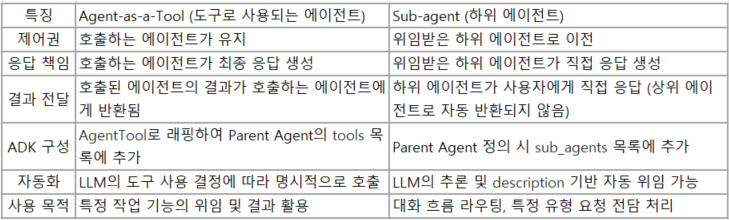

# 2. 구현

## 2.1 환경설정



```
pip install langchain-community crewai-tools wikipedia
```



## 2.2 sub_agent



```
from google.adk import Agent
from google.adk.tools import VertexAiSearchTool
from google.adk.tools.langchain_tool import LangchainTool # import

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from google.adk.tools.crewai_tool import CrewaiTool

from crewai_tools import FileWriterTool

crewai_tool_agent = Agent(
    name="crewai_tool_agent",
    model="gemini-2.0-flash-001",
    description="Agent to write files.",
    instruction="I can write a file if you ask me to keep a note.",
    tools = [CrewaiTool(
        name="file_writer_tool",
        description=(
            "Writes a file to disk when run with a"
            "filename, content, overwrite set to 'true',"
            "and an optional directory"
        ),
        tool=FileWriterTool()
    )]
)

lanchgain_tool_agent = Agent(
    name="lanchgain_tool_agent",
    model="gemini-2.0-flash-001",
    description="Agent to answer questions using Wikipedia.",
    instruction="I can answer your questions by searching Wikipedia! Ask me about a historical figure.",
    tools = [
        LangchainTool(
            tool=WikipediaQueryRun(
              api_wrapper=WikipediaAPIWrapper()
            )
        )
    ]
)

vertexai_search_tool_agent = Agent(
   name="vertexai_search_agent",
   model="gemini-2.0-flash-001",
   description="Answer questions using your data store access.",
   instruction="You analyze new planet discoveries and engage with the scientific community on them.",
   tools=[
    VertexAiSearchTool(
      data_store_id=
        "projects/qwiklabs-gcp-02-279116bdb445/"
        "locations/global/"
        "collections/default_collection/"
        "dataStores/test_1746509813797"
    )
   ]
)


root_agent = Agent(
    name="root_agent",
    model="gemini-2.0-flash-001",
    description="모든 질문에 대해 친절히 답변하는 agent이다.",
    sub_agents=[
        crewai_tool_agent,
        lanchgain_tool_agent,
        vertexai_search_tool_agent
    ]
)
```



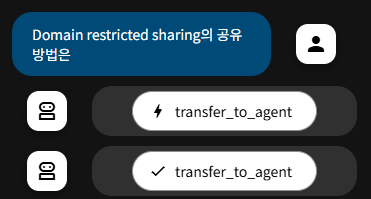

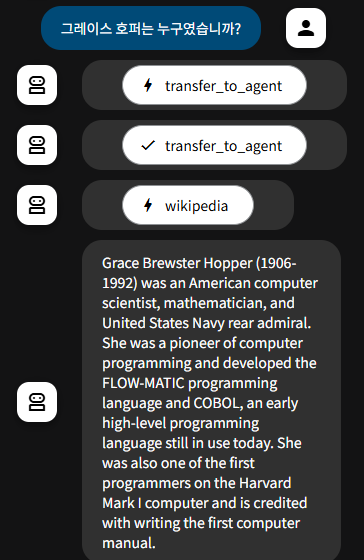

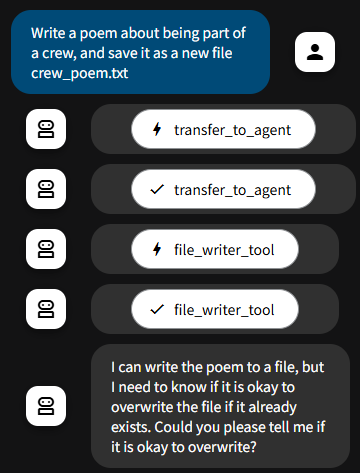

## 2.3 agent as a tool



```
from google.adk import Agent
from google.adk.tools import VertexAiSearchTool
from google.adk.tools.langchain_tool import LangchainTool # import
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from google.adk.tools.crewai_tool import CrewaiTool
from crewai_tools import FileWriterTool
from google.adk.tools import agent_tool

crewai_tool_agent = Agent(
    name="crewai_tool_agent",
    model="gemini-2.0-flash-001",
    description="Agent to write files.",
    instruction="I can write a file if you ask me to keep a note.",
    tools = [CrewaiTool(
        name="file_writer_tool",
        description=(
            "Writes a file to disk when run with a"
            "filename, content, overwrite set to 'true',"
            "and an optional directory"
        ),
        tool=FileWriterTool()
    )]
)

lanchgain_tool_agent = Agent(
    name="lanchgain_tool_agent",
    model="gemini-2.0-flash-001",
    description="Agent to answer questions using Wikipedia.",
    instruction="I can answer your questions by searching Wikipedia! Ask me about a historical figure.",
    tools = [
        LangchainTool(
            tool=WikipediaQueryRun(
              api_wrapper=WikipediaAPIWrapper()
            )
        )
    ]
)

vertexai_search_tool_agent = Agent(
    name="vertexai_search_agent",
    model="gemini-2.0-flash-001",
    description="Answer questions using your data store access.",
    instruction="""
        domain restricted 관련 문의에 대해 vertexai_search_tool에서 대답한다.
    """,
    tools=[
      VertexAiSearchTool(
        data_store_id=
          "projects/qwiklabs-gcp-02-279116bdb445/"
          "locations/global/"
          "collections/default_collection/"
          "dataStores/test_1746509813797"
      )
    ]
)
crewai_tool = agent_tool.AgentTool(agent=crewai_tool_agent)
lanchgain_tool = agent_tool.AgentTool(agent=lanchgain_tool_agent)
vertexai_search_tool = agent_tool.AgentTool(agent=vertexai_search_tool_agent)
root_agent = Agent(
    name="root_agent",
    model="gemini-2.0-flash-001",
    description="모든 질문에 대해 친절히 답변하는 agent이다.",
    instruction="""
        domain restricted 관련 문의는 vertexai_search_tool이 처리한다.
        사람 관련 질문은 lanchgain_tool이 처리한다.
        파일 관련 질문은 crewai_tool이 처리한다.
        이 외에는 root_agent가 알아서 처리한다.
    """,
    tools=[
        crewai_tool,
        lanchgain_tool,
        vertexai_search_tool
    ]
)

```



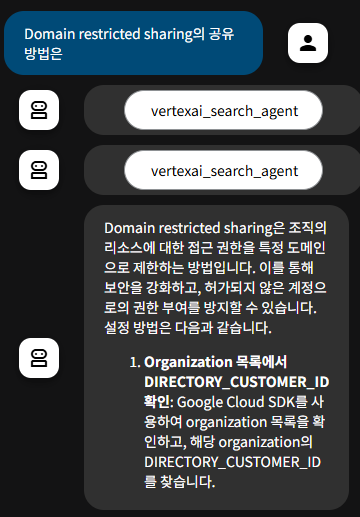

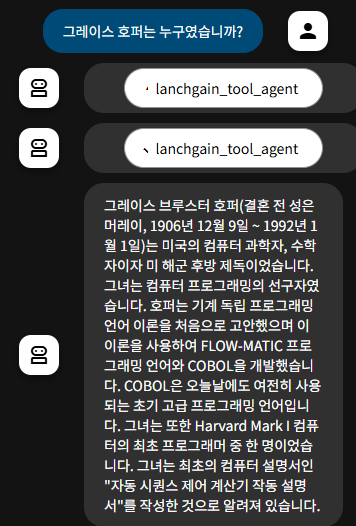

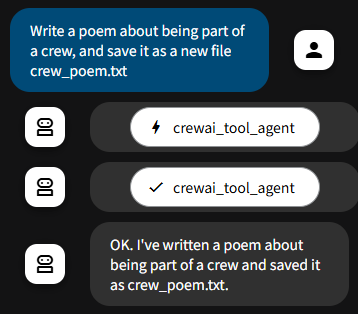

# 3. reference

* https://google.github.io/adk-docs/agents/multi-agents/#c-explicit-invocation-agenttool